## Export pipeline and EDA od the labeled data

The corpus has 1,877 posts out of 7,394 posts with at least one manipulation technique. 
The total number of manipulation technique instances found in the posts is 3,472. 

The most common manipulation techniques are Loaded Language and other Emotions (1,119 instances), Appeal to Fear (633 instances), Doubts in Government (544 instances), and Appeal to Anger (501 instances). 

The least common techniques are Other Doubts in Ukraine (12 instances) and Doubts in Partners’ help (35 instances). 

The average length of the manipulation fragment is 30 characters. On average, the longest technique is the Black-and-white fallacy with 68 characters, while the shortest is the Loaded Language and other Emotions technique with 14 characters.


In [2]:
import pandas as pd
import re
import os
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Data load

In [13]:
file_path = 'C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/data/annotation/exports'
df_export = pd.read_json((os.path.join(file_path, "annotation_manipulation_techniques_8000_with_correction_C.ndjson")), lines = True)
df_export.head()

,data_row,media_attributes,projects
0,"{'id': 'clt5q7yum1tgh0717mgwq59fv', 'external_...",{'mime_type': 'text/plain'},{'clt5ogjql006j07wifgvvbeyq': {'name': 'annota...
1,"{'id': 'clt5q7yum1tgi0717y9u4a6uo', 'external_...",{'mime_type': 'text/plain'},{'clt5ogjql006j07wifgvvbeyq': {'name': 'annota...
2,"{'id': 'clt5q7yum1tgj0717e5d1j0r2', 'external_...",{'mime_type': 'text/plain'},{'clt5ogjql006j07wifgvvbeyq': {'name': 'annota...
3,"{'id': 'clt5q7yum1tgk0717xbh9cv5e', 'external_...",{'mime_type': 'text/plain'},{'clt5ogjql006j07wifgvvbeyq': {'name': 'annota...
4,"{'id': 'clt5q7yum1tgl0717tkpf0mvf', 'external_...",{'mime_type': 'text/plain'},{'clt5ogjql006j07wifgvvbeyq': {'name': 'annota...


In [14]:
# Extract annotations
def extract_annotations(projects):
  annotations = []
  for project_id, project_data in projects.items():
    for label_data in project_data['labels']:
      for annotation in label_data['annotations']['objects']:
        annotation_info={
            'name': annotation['name'],
            'token': annotation['location']['token'],
            'start': annotation['location']['start'],
            'end': annotation['location']['end'],
        }
        annotations.append(annotation_info)
  return annotations

In [15]:
def extract_is_manipulation(projects):
    is_manipulated = False
    for project_id, project_data in projects.items():
        for label_data in project_data['labels']:
            for i in label_data['annotations']['classifications']:        
        # Extracting the first value and converting to boolean
                is_manipulated = i['radio_answer']['name'] == 'Так'
        # Break the loop after extracting the first value
                break
            if is_manipulated:
                break
        if is_manipulated:
            break
          
    return is_manipulated

In [16]:
# Extract message id 
df_export["message_id"] = df_export["data_row"].apply(lambda x: x["external_id"].replace('message_', '').replace('.txt', ''))
#Convert message_id ti int
df_export["message_id"] = df_export["message_id"].apply(ast.literal_eval)
# Extract annotations
df_export['annotations'] = df_export["projects"].apply(extract_annotations)
# Extract wheteher is text is manipulations
df_export["is_manipulation"]= df_export['projects'].apply(extract_is_manipulation)
df_export = df_export[["message_id", "annotations", "is_manipulation"]]

In [17]:
df_export.head()

,message_id,annotations,is_manipulation
0,209742,[],False
1,209744,[],False
2,209751,"[{'name': 'Emotion_other', 'token': 'легендарн...",True
3,209753,[],False
4,209760,[],False


#### Remove ads (if any)

In [19]:
# Download dataset with text
df_text = pd.read_csv('C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/teleg_news_channels/data_preprocessed.csv')
# Choose only post in Ukrainian
df_text = df_text[df_text["lang"] == 'uk']
df_text.rename(columns={"Unnamed: 0" : "message_id"}, inplace=True)
# Add texts
df_with_text = pd.merge(df_text, df_export, on='message_id', how='inner') 
selected_columns = ["message_id", "message_content", "annotations", "is_manipulation"]
df_with_text = df_with_text[selected_columns]
df_with_text.head()

,message_id,message_content,annotations,is_manipulation
0,209742,Цигарки блоками за най нижчими цінами в Украї...,[],False
1,209744,"⚡️Окупанти завдали 6 ударів ракетами С-300, – ...",[],False
2,209751,"➡️ «Доброго вечора, ми з України» – легендарни...","[{'name': 'Emotion_other', 'token': 'легендарн...",True
3,209753,Новий стінопис з військовим зʼявився на стінах...,[],False
4,209760,✨Чуєте святковий настрій? Новорічні знижки у с...,[],False


In [20]:
# Clean all text from advertizing
ad_key_words = ["#реклама", "UPG", "Що подивитися на вихідних", "заплатимо тобі гроші", "у вас є крутий відос або фото?", "Терміново знімайте та надсилайте мені!", "ПЛАТИТЬ ГРОШІ ЗА КОНТЕНТ", "#хвостатий_вечір", "фільмів", "Куди піти", "WOG", "заклад працює", "Ми знаходимось", "Вакансія"]
mask = df_with_text["message_content"].str.contains('|'.join(ad_key_words), case=True)  #case=True - case sensitive, exactly
ads= df_with_text[mask] # add

In [21]:
# Remove what does not need
ads.loc[ads['message_id'] == 1128494, 'is_manipulation'] = False
ads.loc[ads['message_id'] == 315402, 'is_manipulation'] = False

ads = ads[ads["is_manipulation"]==False]

In [22]:
# Remove advertising if any
df_with_text= df_with_text[~mask] # remove
print("The Number of posts:", len(df_with_text))

The Number of posts: 7394


#### Choose only rows with any annotations

In [23]:
# Choose only rows with any annotations
df_ismanipulation = df_with_text[df_with_text["is_manipulation"]== True]

#check if ismanipulation status is correct
annotations_non_empty = df_ismanipulation['annotations'].apply(lambda x: isinstance(x, list) and len(x) > 0)
if annotations_non_empty.all():
    print("All True texts have non-empty annotations")
else:
    print("There are texts with empty annotations in True")

There are texts with empty annotations in True


In [24]:
# If there are
# Filter the DataFrame to include only rows where the "annotations" column contains empty lists

ismanipulation_df_with_empty_annotations = df_ismanipulation[~annotations_non_empty]
need_to_be_changed_ids_to_false = ismanipulation_df_with_empty_annotations["message_id"].tolist()

In [25]:
# Change the status to the right one if changes are needed
df_with_text.loc[df_with_text['message_id'].isin(need_to_be_changed_ids_to_false), 'is_manipulation'] = False
# Choose only rows with any annotations
df_ismanipulation = df_with_text[df_with_text["is_manipulation"]== True]

#check if ismanipulation status is correct
annotations_non_empty = df_ismanipulation['annotations'].apply(lambda x: isinstance(x, list) and len(x) > 0)
if annotations_non_empty.all():
    print("All True texts have non-empty annotations")
else:
    print("There are texts with empty annotations in True")

All True texts have non-empty annotations


In [26]:
# Choose only rows with zero annotations
df_notmanipulation = df_export[df_export["is_manipulation"]== False]

#check if ismanipulation status is correct
annotations_empty = df_notmanipulation['annotations'].apply(lambda x: isinstance(x, list) and len(x) > 0)
if annotations_empty.all():
    print("There are non-empty annotations in False")
else:
    print("All texts have empty annotations in False")

All texts have empty annotations in False


In [27]:
print("Number of the posts with manipulation:", len(df_ismanipulation))

Number of the posts with manipulation: 1877


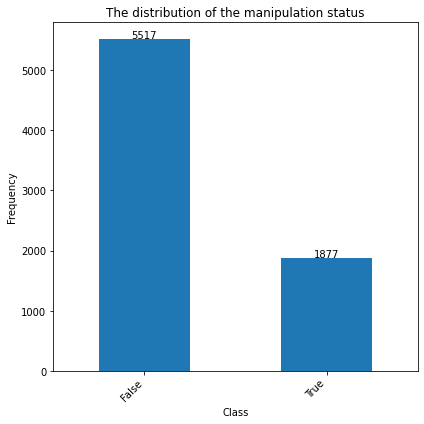

In [28]:
# Count the occurrences of each class
is_manipulation = df_with_text["is_manipulation"].value_counts()

# Plot the frequency of each class
plt.figure(figsize=(6, 6))
ax = is_manipulation.plot(kind='bar')
plt.title('The distribution of the manipulation status')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

# Add numbers on top of the bar
for i, v in enumerate(is_manipulation):
    ax.text(i, v+10, str(v), ha='center')
plt.tight_layout()
plt.show()

#### Add texts

In [29]:
# Remove everything except for text, numbers and punctuation
punctuation = "!*(),-.–:;?%/"
russian_letters = u"абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ"
ukrainian_alphabet = u"АБВГҐДЕЄЖЗИІЇЙКЛМНОПРСТУФХЦЧШЩЬЮЯабвгґдеєжзиіїйклмнопрстуфхцчшщьюя"
latin_letters_numbers = "1234567890abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ "
allowed_symbols = ukrainian_alphabet+russian_letters+latin_letters_numbers+punctuation

def clean_text(text, allowed_symbols=""):
    # Remove newline characters, carriage returns, and repr symbols
    cleaned_text = re.sub(r'[\n\r\t\\]+', ' ', text)
    # Remove multiple spaces 
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    # Clean the messages from all emojis
    pattern = r'[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\U0001F700-\U0001F77F\U0001F780-\U0001F7FF\U0001F800-\U0001F8FF\U0001F900-\U0001F9FF\U0001FA00-\U0001FA6F\U0001FA70-\U0001FAFF\U00002702-\U000027B0\U000024C2-\U0001F251&&[^\uFF01-\uFF5E]]+'
    cleaned_text = re.sub(pattern, '', cleaned_text)
    # Remove URLs
    cleaned_text = re.sub(r'http[s]?://\S+', '', cleaned_text)
    # Remove everything except for allowed symbols if specified
    if allowed_symbols:
        cleaned_text = ''.join(char for char in cleaned_text if char in allowed_symbols)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text)
    return cleaned_text

In [30]:
# Clean messages text
df_ismanipulation["message_clean"] = df_ismanipulation["message_content"].apply(lambda x: clean_text(x,allowed_symbols))

C:\Windows\Temp\ipykernel_15188\1771681459.py:15: FutureWarning: Possible set intersection at position 232
  cleaned_text = re.sub(pattern, '', cleaned_text)
C:\Windows\Temp\ipykernel_15188\2771992391.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ismanipulation["message_clean"] = df_ismanipulation["message_content"].apply(lambda x: clean_text(x,allowed_symbols))


In [31]:
df_ismanipulation["message_clean"].isna().value_counts()

False    1877
Name: message_clean, dtype: int64

#### Extract name and token

In [32]:
# Explode the rows
df_ismanipulation["annotations_exploded"] = df_ismanipulation["annotations"]
df_ismanipulation = df_ismanipulation.explode("annotations_exploded")
# Convert 'annotations' to DataFrame
df_an = pd.DataFrame(df_ismanipulation['annotations_exploded'].tolist(), index=df_ismanipulation.index)
# Merge with original DataFrame on index to retain 'message_id'
df_ismanipulation = pd.concat([df_ismanipulation.drop(columns="annotations_exploded"), df_an], axis=1)
df_ismanipulation.head()

C:\Windows\Temp\ipykernel_15188\3458851843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ismanipulation["annotations_exploded"] = df_ismanipulation["annotations"]


,message_id,message_content,annotations,is_manipulation,message_clean,name,token,start,end
2,209751,"➡️ «Доброго вечора, ми з України» – легендарни...","[{'name': 'Emotion_other', 'token': 'легендарн...",True,"доброго вечора, ми з україни – легендарний ви...",Emotion_other,легендарний,46,56
2,209751,"➡️ «Доброго вечора, ми з України» – легендарни...","[{'name': 'Emotion_other', 'token': 'легендарн...",True,"доброго вечора, ми з україни – легендарний ви...",Doubts_media,"те, що не покажуть звичайні новини",209,242
5,209779,😱Мільйон гривень за шкільний туалет витратять ...,"[{'name': 'Doubts_government', 'token': 'Це як...",True,мільйон гривень за шкільний туалет витратять у...,Doubts_government,Це якийсь новий тендерний тренд?,382,413
5,209779,😱Мільйон гривень за шкільний туалет витратять ...,"[{'name': 'Doubts_government', 'token': 'Це як...",True,мільйон гривень за шкільний туалет витратять у...,Doubts_government,Це якийсь новий тендерний тренд?,382,413
7,209784,❗️Вручення повісток у спортзалах є законним: «...,"[{'name': 'Black_White', 'token': '«Чоловіки п...",True,вручення повісток у спортзалах є законним: кач...,Black_White,"«Чоловіки призовного віку, які свідомо уникаюч...",93,284


In [33]:
# Change End and Start with mo emoji and spaces
# Clean messages text
df_ismanipulation["token_clean"] = df_ismanipulation["token"].apply(lambda x: clean_text(x,allowed_symbols))
# Check if there are empty token_clean 
remove = df_ismanipulation[df_ismanipulation["token_clean"] == ""]
remove.head()

,message_id,message_content,annotations,is_manipulation,message_clean,name,token,start,end,token_clean
156,211006,Поранив хлопця ножем в голову😨\n\nПоліція огол...,"[{'name': 'Emotion_other', 'token': 'Який треш...",True,поранив хлопця ножем в голову поліція оголосил...,Emotion_Anger,🤬,212,213,
188,211361,🤬 С-300 русня атакувала Харківщину сьогодні.\n...,"[{'name': 'Emotion_Anger', 'token': '🤬', 'star...",True,с-300 русня атакувала харківщину сьогодні. пр...,Emotion_Anger,🤬,10,11,
525,316700,Випадок захворювання на лептоспіроз зафіксувал...,"[{'name': 'Emotion_Fear', 'token': '🤯', 'start...",True,випадок захворювання на лептоспіроз зафіксувал...,Emotion_Fear,🤯,69,70,
2016,716140,Пздц! ТРУЯТЬ собак на Стрілецькій 🤯\n\n#меніпи...,"[{'name': 'Emotion_other', 'token': 'Пздц', 's...",True,пздц! труять собак на стрілецькій меніпишуть н...,Emotion_other,🤯,44,45,
4291,1066327,❗️Нова ПАНДЕМІЯ? Китайські вчені відкрили вісі...,"[{'name': 'Emotion_Fear', 'token': '🤯', 'start...",True,нова пандемія? китайські вчені відкрили вісім ...,Emotion_Fear,🤯,85,86,


In [34]:
# Remove token_clean if there are empty
df_ismanipulation = df_ismanipulation[df_ismanipulation['token_clean'].apply(clean_text).str.strip() != ""]

In [35]:
# Change start and end
start_indices =[]
end_indices  =[]

for index, row in df_ismanipulation.iterrows():
    token = row["token_clean"]
    message =  row["message_clean"]
    start = message.find(token)
    end = start +len(token) -1
    start_indices .append(start)
    end_indices.append(end)


df_ismanipulation["start_new"] = start_indices
df_ismanipulation["end_new"] = end_indices

In [36]:
df_ismanipulation["end_new"].isnull().value_counts()

False    4260
Name: end_new, dtype: int64

In [38]:
print("Lenght:", len(df_ismanipulation))
df_ismanipulation.head()

Lenght: 4260


,message_id,message_content,annotations,is_manipulation,message_clean,name,token,start,end,token_clean,start_new,end_new
2,209751,"➡️ «Доброго вечора, ми з України» – легендарни...","[{'name': 'Emotion_other', 'token': 'легендарн...",True,"доброго вечора, ми з україни – легендарний ви...",Emotion_other,легендарний,46,56,легендарний,32,42
2,209751,"➡️ «Доброго вечора, ми з України» – легендарни...","[{'name': 'Emotion_other', 'token': 'легендарн...",True,"доброго вечора, ми з україни – легендарний ви...",Doubts_media,"те, що не покажуть звичайні новини",209,242,"те, що не покажуть звичайні новини",192,225
5,209779,😱Мільйон гривень за шкільний туалет витратять ...,"[{'name': 'Doubts_government', 'token': 'Це як...",True,мільйон гривень за шкільний туалет витратять у...,Doubts_government,Це якийсь новий тендерний тренд?,382,413,це якийсь новий тендерний тренд?,358,389
5,209779,😱Мільйон гривень за шкільний туалет витратять ...,"[{'name': 'Doubts_government', 'token': 'Це як...",True,мільйон гривень за шкільний туалет витратять у...,Doubts_government,Це якийсь новий тендерний тренд?,382,413,це якийсь новий тендерний тренд?,358,389
7,209784,❗️Вручення повісток у спортзалах є законним: «...,"[{'name': 'Black_White', 'token': '«Чоловіки п...",True,вручення повісток у спортзалах є законним: кач...,Black_White,"«Чоловіки призовного віку, які свідомо уникаюч...",93,284,"чоловіки призовного віку, які свідомо уникаючи...",76,264


#### Remove duplicates for posts with consensus

In [39]:
# Find posts with duplicades in list of posts with consensus
list = pd.read_csv("C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/list_with_consensus_post.csv")
list = list["message_id"]
list = list.values.tolist()
list

[209779,
 210009,
 210028,
 210588,
 210590,
 210878,
 210911,
 211048,
 211070,
 211122,
 211431,
 212018,
 212123,
 212152,
 212298,
 315326,
 315353,
 315384,
 315445,
 315493,
 315497,
 315533,
 315535,
 315564,
 315684,
 315716,
 315800,
 315960,
 315987,
 315993,
 316025,
 316138,
 316139,
 316157,
 316210,
 316250,
 316384,
 316645,
 316676,
 316698,
 316701,
 316745,
 316750,
 316754,
 316812,
 321591,
 321596,
 321618,
 321641,
 321703,
 321756,
 321798,
 321817,
 321855,
 322155,
 322179,
 322192,
 322346,
 322364,
 322443,
 322560,
 322594,
 322723,
 322817,
 322838,
 322997,
 323265,
 334747,
 357519,
 373775,
 379915,
 386616,
 395098,
 398162,
 401299,
 406390,
 406613,
 410220,
 416563,
 445031,
 477294,
 477454,
 477523,
 477651,
 477853,
 477883,
 477920,
 478037,
 478237,
 478286,
 478441,
 478442,
 478632,
 478668,
 478835,
 478916,
 479027,
 479045,
 479193,
 479210,
 479338,
 543177,
 543210,
 543315,
 543316,
 543353,
 543458,
 543780,
 543811,
 544053,
 544498,
 

In [40]:
# Remove duplicates
# Split the DataFrame into two parts: those with ids in ids_list and those without
df_to_deduplicate = df_ismanipulation[df_ismanipulation['message_id'].isin(list)]
df_remaining = df_ismanipulation[~df_ismanipulation['message_id'].isin(list)]

# Remove duplicates based on 'id' and 'token' for the filtered df
df_to_deduplicate_no_duplicates = df_to_deduplicate.drop_duplicates(subset=['message_id', 'token_clean'])

# Combine the deduplicated part with the remaining part of the original df
df_ismanipulation_final = pd.concat([df_to_deduplicate_no_duplicates, df_remaining], ignore_index=True)
print("Lenght:", len(df_ismanipulation_final))
df_ismanipulation.head()

Lenght: 3471


,message_id,message_content,annotations,is_manipulation,message_clean,name,token,start,end,token_clean,start_new,end_new
2,209751,"➡️ «Доброго вечора, ми з України» – легендарни...","[{'name': 'Emotion_other', 'token': 'легендарн...",True,"доброго вечора, ми з україни – легендарний ви...",Emotion_other,легендарний,46,56,легендарний,32,42
2,209751,"➡️ «Доброго вечора, ми з України» – легендарни...","[{'name': 'Emotion_other', 'token': 'легендарн...",True,"доброго вечора, ми з україни – легендарний ви...",Doubts_media,"те, що не покажуть звичайні новини",209,242,"те, що не покажуть звичайні новини",192,225
5,209779,😱Мільйон гривень за шкільний туалет витратять ...,"[{'name': 'Doubts_government', 'token': 'Це як...",True,мільйон гривень за шкільний туалет витратять у...,Doubts_government,Це якийсь новий тендерний тренд?,382,413,це якийсь новий тендерний тренд?,358,389
5,209779,😱Мільйон гривень за шкільний туалет витратять ...,"[{'name': 'Doubts_government', 'token': 'Це як...",True,мільйон гривень за шкільний туалет витратять у...,Doubts_government,Це якийсь новий тендерний тренд?,382,413,це якийсь новий тендерний тренд?,358,389
7,209784,❗️Вручення повісток у спортзалах є законним: «...,"[{'name': 'Black_White', 'token': '«Чоловіки п...",True,вручення повісток у спортзалах є законним: кач...,Black_White,"«Чоловіки призовного віку, які свідомо уникаюч...",93,284,"чоловіки призовного віку, які свідомо уникаючи...",76,264


#### EDA

In [41]:
# Count the avr lenght for each class
df_ismanipulation_final['length'] = df_ismanipulation_final['token'].str.len()

classes = df_ismanipulation_final["name"].value_counts()
average_lengths = df_ismanipulation_final.groupby("name")["length"].mean().round(2)
result = pd.DataFrame({
    'frequency': classes,
    'average_length': average_lengths
})

# Calculate the total frequency and average length
total_frequency = df_ismanipulation_final.shape[0]
total_average_length = df_ismanipulation_final["length"].mean().round(2)

# Append the "Total" row to the result DataFrame
total_row = pd.DataFrame({
    'frequency': [total_frequency],
    'average_length': [total_average_length]
}, index=['Total'])

result = pd.concat([result, total_row])

print(result)

                      frequency  average_length
Black_White                 105           67.48
Doubts_Army                  81           53.59
Doubts_government           544           42.71
Doubts_media                 61           45.31
Doubts_other                 12           51.75
Doubts_partners              35           52.20
Emotion_Anger               501           37.12
Emotion_Fear                633           34.48
Emotion_Hate_Disgust        380           19.79
Emotion_other              1119           13.52
Total                      3471           29.66


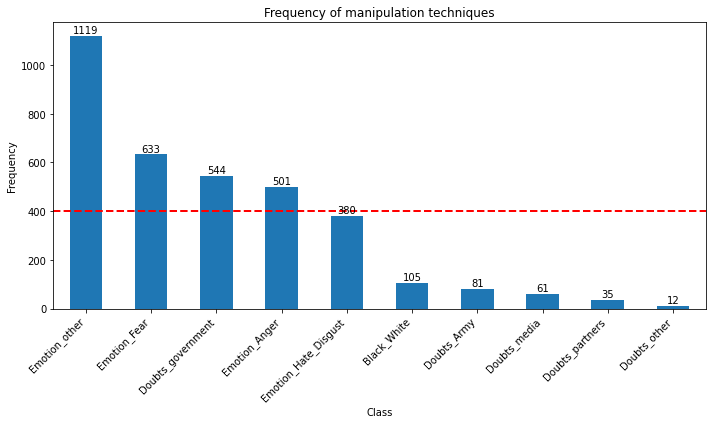

In [42]:
# Count the occurrences of each class
classes = df_ismanipulation_final["name"].value_counts()

# Plot the frequency of each class
plt.figure(figsize=(10, 6))
ax = classes.plot(kind='bar')
plt.title('Frequency of manipulation techniques')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

# Add numbers on top of the bar
for i, v in enumerate(classes):
    ax.text(i, v+10, str(v), ha='center')
    
# Add red line
plt.axhline(y=400, color='r', linestyle='--', linewidth=2)

plt.tight_layout()
plt.show()

### Convert to the proper format

In [43]:
# Combine values into a dictionary and create the new column
df_ismanipulation_final['annotation_new'] = df_ismanipulation_final.apply(lambda row: {'name': row['name'], 'start': row['start_new'], 'end': row['end_new']}, axis=1)

In [44]:
df_pred = df_ismanipulation_final[['message_id', 'message_clean', 'annotation_new']]
merged_df = df_pred.groupby('message_id').agg({'message_clean': 'first', 'annotation_new': lambda x: x.tolist()}).reset_index()
merged_df.head()

,message_id,message_clean,annotation_new
0,209751,"доброго вечора, ми з україни – легендарний ви...","[{'name': 'Emotion_other', 'start': 32, 'end':..."
1,209779,мільйон гривень за шкільний туалет витратять у...,"[{'name': 'Doubts_government', 'start': 358, '..."
2,209784,вручення повісток у спортзалах є законним: кач...,"[{'name': 'Black_White', 'start': 76, 'end': 2..."
3,209785,окупанти продовжують терор мирного населення х...,"[{'name': 'Emotion_Fear', 'start': 21, 'end': ..."
4,209789,"загинув чоловік через обстріл вовчанська, – ов...","[{'name': 'Emotion_Fear', 'start': 215, 'end':..."


In [44]:
# Save 
merged_df.to_csv("C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/input_only_manipulations_clean_full.csv", index=False)

#### Devide to train and dev 

In [45]:
train_ids, dev_ids = train_test_split(merged_df["message_id"].unique(), test_size=0.3, random_state=108)
# Filter the data based on the train and test IDs
train_df = merged_df[merged_df['message_id'].isin(train_ids)]
dev_df = merged_df[merged_df['message_id'].isin(dev_ids)]
print("Length of the train:", len(train_df))
print("Length of the dev:", len(dev_df))

Length of the train: 1308
Length of the dev: 561


In [46]:
# Check the frequences of each class in train df
all_names = [item['name'] for sublist in train_df['annotation_new'] for item in sublist]

# Count occurrences of each unique 'name'
name_counts = pd.Series(all_names).value_counts(normalize=True)
print("In the train dataset:")
print(name_counts)

In the train dataset:
Emotion_other           0.320213
Emotion_Fear            0.186142
Doubts_government       0.164002
Emotion_Anger           0.140631
Emotion_Hate_Disgust    0.112751
Black_White             0.027880
Doubts_Army             0.021320
Doubts_media            0.013940
Doubts_partners         0.009020
Doubts_other            0.004100
dtype: float64


In [47]:
# Check the frequences of each class in dev df
all_names = [item['name'] for sublist in dev_df['annotation_new'] for item in sublist]

# Count occurrences of each unique 'name'
name_counts = pd.Series(all_names).value_counts(normalize=True)
print("In the dev dataset:")
print(name_counts)

In the dev dataset:
Emotion_other           0.327519
Emotion_Fear            0.173450
Emotion_Anger           0.153101
Doubts_government       0.139535
Emotion_Hate_Disgust    0.101744
Black_White             0.035853
Doubts_Army             0.028101
Doubts_media            0.026163
Doubts_partners         0.012597
Doubts_other            0.001938
dtype: float64


#### Calculate weights for each class in train df

In [48]:
techniques = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/propaganda-techniques-names.txt"
class_dict = {}  #to dictionary
label = 0
with open(techniques, "r") as f:
  for technique in f:
    class_dict[technique.replace("\n", "")] = int(label)
    label += 1

In [49]:
def calculate_class_weights(df):
    """
    Calculates class weights based on the frequency of each class in the dataset
    """
    class_counts = df.value_counts()
    total_samples = len(df)
    class_weights = total_samples / class_counts
    return class_weights

# Calculate class weights
df_fr = pd.DataFrame(all_names, columns=['Class'])
df_fr['Class'] = df_fr['Class'].map(class_dict)
class_weights = calculate_class_weights(df_fr['Class'])
class_weights

9      3.053254
6      5.765363
7      6.531646
0      7.166667
8      9.828571
5     27.891892
1     35.586207
2     38.222222
3     79.384615
4    516.000000
Name: Class, dtype: float64

In [50]:
# Save class weights to a text file
with open('C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/class_weights_10_numbers.txt', 'w') as f:
    for class_name, weight in class_weights.items():
        f.write(f"{class_name}: {weight}\n")

#### Save train and dev datasets

In [51]:
# Save train and def
train_df.to_csv("C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/input_train_new.csv", index=False)
dev_df.to_csv("C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/input_dev_new.csv", index=False)

In [52]:
# Save text for train 
output_dir = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/train_new"

# Initialize tqdm progress bar
pbar = tqdm(total=len(train_df), desc='Saving Files')

# Iterate over each row in the DataFrame
for _, row in train_df.iterrows():
    # Extract message_id
    message_id = row["message_id"]
    text = row["message_clean"]

    # Create file name
    file_name = f"article{message_id}.txt"
    
    # Write the content to a file
    with open(os.path.join(output_dir, file_name), "w", encoding='utf-8') as file:
        file.write(text)
        
    # Update tqdm progress bar
    pbar.update(1)

print("All files are saved.")

Saving Files:  85%|████████▌ | 1118/1308 [00:00<00:00, 1876.51it/s]

All files are saved.


In [53]:
# Save text for dev 
output_dir = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/dev_new"

# Initialize tqdm progress bar
pbar = tqdm(total=len(dev_df), desc='Saving Files')

# Iterate over each row in the DataFrame
for _, row in dev_df.iterrows():
    # Extract message_id
    message_id = row["message_id"]
    text = row["message_clean"]

    # Create file name
    file_name = f"article{message_id}.txt"
    
    # Write the content to a file
    with open(os.path.join(output_dir, file_name), "w", encoding='utf-8') as file:
        file.write(text)
        
    # Update tqdm progress bar
    pbar.update(1)

print("All files are saved.")


Saving Files: 100%|██████████| 1308/1308 [00:14<00:00, 88.20it/s]  

Saving Files:  72%|███████▏  | 404/561 [00:00<00:00, 1996.51it/s]

All files are saved.


#### SI task

In [41]:
# Save labels for train for SI
output_dir = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/train_SI_labels"

# Initialize tqdm progress bar
pbar = tqdm(total=len(train_df), desc='Saving Files')

# Iterate over each row in the DataFrame
for _, row in train_df.iterrows():
    # Extract message_id
    message_id = row["message_id"]
    
    # Create an empty list to store the lines to be written to the file
    lines = []

    # Iterate over each annotation in the 'annotations' column
    for annotation in row["annotation_new"]:
        # Extract information from the annotation
        start = annotation["start"]
        end = annotation["end"]
        
        # Construct the line to be written to the file
        line = f"{message_id}\t{start}\t{end}"
        
        # Append the line to the list
        lines.append(line)


    # Join all lines with newline characters to create the content of the file
    file_content = "\n".join(lines)
    # Create file name
    file_name = f"article{message_id}.labels.tsv"
    
    # Write the content to a file
    with open(os.path.join(output_dir, file_name), "w", encoding='utf-8') as file:
        file.write(file_content)
        
    # Update tqdm progress bar
    pbar.update(1)

print("All files are saved.")

Saving Files:  93%|█████████▎| 1242/1333 [00:00<00:00, 1712.22it/s]

All files are saved.


In [42]:
# Save labels for dev for SI
output_dir = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/dev_SI_labels"

# Initialize tqdm progress bar
pbar = tqdm(total=len(dev_df), desc='Saving Files')

# Iterate over each row in the DataFrame
for _, row in dev_df.iterrows():
    # Extract message_id
    message_id = row["message_id"]
    
    # Create an empty list to store the lines to be written to the file
    lines = []

    # Iterate over each annotation in the 'annotations' column
    for annotation in row["annotation_new"]:
        # Extract information from the annotation
        start = annotation["start"]
        end = annotation["end"]
        
        # Construct the line to be written to the file
        line = f"{message_id}\t{start}\t{end}"
        
        # Append the line to the list
        lines.append(line)


    # Join all lines with newline characters to create the content of the file
    file_content = "\n".join(lines)
    # Create file name
    file_name = f"article{message_id}.labels.tsv"
    
    # Write the content to a file
    with open(os.path.join(output_dir, file_name), "w", encoding='utf-8') as file:
        file.write(file_content)
        
    # Update tqdm progress bar
    pbar.update(1)

print("All files are saved.")


Saving Files: 100%|██████████| 1333/1333 [00:02<00:00, 604.79it/s] 

Saving Files:  72%|███████▏  | 414/572 [00:00<00:00, 2058.46it/s]

All files are saved.


In [43]:
# Save truth labels  for techniques
output_dir = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets"

lines = []
# Iterate over each row in the DataFrame
for _, row in dev_df.iterrows():
    # Extract message_id
    message_id = row["message_id"]

    # Iterate over each annotation in the 'annotations' column
    for annotation in row["annotation_new"]:
        # Extract information from the annotation
        start = annotation["start"]
        #name = annotation["name"]
        end = annotation["end"]
        
        # Construct the line to be written to the file
        line = f"{message_id}\t{start}\t{end}"
        
        # Append the line to the list
        lines.append(line)

# Join all lines with newline characters to create the content of the file
file_content = "\n".join(lines)
    
# Write the content to a file
with open(os.path.join(output_dir, "SI.labels_true.txt"), "w", encoding='utf-8') as file:
        file.write(file_content)

#### TC 10 task

In [54]:
# Save labels for train for TC
output_dir = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets/train_TC_labels"

# Initialize tqdm progress bar
pbar = tqdm(total=len(train_df), desc='Saving Files')

# Iterate over each row in the DataFrame
for _, row in train_df.iterrows():
    # Extract message_id
    message_id = row["message_id"]
    
    # Create an empty list to store the lines to be written to the file
    lines = []

    # Iterate over each annotation in the 'annotations' column
    for annotation in row["annotation_new"]:
        # Extract information from the annotation
        name = annotation["name"]
        #token = annotation["token"]
        start = annotation["start"]
        end = annotation["end"]
        
        # Construct the line to be written to the file
        line = f"{message_id}\t{name}\t{start}\t{end}"
        
        # Append the line to the list
        lines.append(line)


    # Join all lines with newline characters to create the content of the file
    file_content = "\n".join(lines)
    # Create file name
    file_name = f"article{message_id}.labels.tsv"
    
    # Write the content to a file
    with open(os.path.join(output_dir, file_name), "w", encoding='utf-8') as file:
        file.write(file_content)
        
    # Update tqdm progress bar
    pbar.update(1)

print("All files are saved.")

Saving Files:  97%|█████████▋| 1274/1308 [00:00<00:00, 2121.09it/s]

All files are saved.


In [55]:
# Save template for techniques pred
output_dir = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets"

lines = []
# Iterate over each row in the DataFrame
for _, row in dev_df.iterrows():
    # Extract message_id
    message_id = row["message_id"]

    # Iterate over each annotation in the 'annotations' column
    for annotation in row["annotation_new"]:
        # Extract information from the annotation
        start = annotation["start"]
        end = annotation["end"]
        
        # Construct the line to be written to the file
        line = f"{message_id}\t?\t{start}\t{end}"
        
        # Append the line to the list
        lines.append(line)

# Join all lines with newline characters to create the content of the file
file_content = "\n".join(lines)
    
# Write the content to a file
with open(os.path.join(output_dir, "TC_labels_for_eval.txt"), "w", encoding='utf-8') as file:
        file.write(file_content)

In [56]:
# Save truth labels  for techniques
output_dir = "C:/N/st/UCU/5sem2024_DIPLOMA/Manipulation/code/my_master/datasets"

lines = []
# Iterate over each row in the DataFrame
for _, row in dev_df.iterrows():
    # Extract message_id
    message_id = row["message_id"]

    # Iterate over each annotation in the 'annotations' column
    for annotation in row["annotation_new"]:
        # Extract information from the annotation
        start = annotation["start"]
        name = annotation["name"]
        end = annotation["end"]
        
        # Construct the line to be written to the file
        line = f"{message_id}\t{name}\t{start}\t{end}"
        
        # Append the line to the list
        lines.append(line)

# Join all lines with newline characters to create the content of the file
file_content = "\n".join(lines)
    
# Write the content to a file
with open(os.path.join(output_dir, "TC.labels_true.txt"), "w", encoding='utf-8') as file:
        file.write(file_content)